<a href="https://colab.research.google.com/github/kazars24/tinkoff-dl-fall22/blob/main/Neural%20Network%20Training/seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks practice

The ultimate goal of this notebook is to gain intuition in how neural networks should work.

First, we'll look into some building blocks:
- Activation functions
- Loss function
- Dense Layer

Then, we'll get an idea of how the backpropogation algorithm works.

Finally, we'll build a simple neural network on MNIST classification task.

Let's get started.

In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, List, Optional, Tuple


plt.style.use('dark_background')

### Activation functions

In this notebook we'll only examine ReLU nonlinearity function, although there are much more nonlinearities you can apply in your neural network.

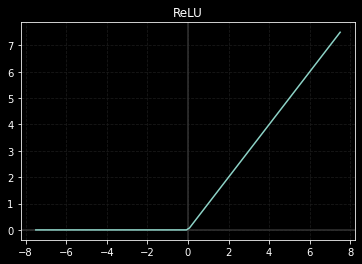

In [2]:
relu: Callable[[np.ndarray], np.ndarray] = \
    lambda x: np.where(x < 0, 0, x)

plt.axhline(c='.2')
plt.axvline(color='.2')
plt.grid(c='.1', ls='--')


z = torch.linspace(-7.5, 7.5, 100)
plt.plot(z, relu(z))
plt.title("ReLU")
plt.show()

### Softmax

![softmax](misc/softmax.png)

In [3]:
softmax1: Callable[[np.ndarray], np.ndarray] = \
    lambda x: np.exp(x) / np.sum(np.exp(x), -1)[:, None]

In [4]:
def softmax2(x: np.ndarray) -> np.ndarray:
    """
        x: array of shape [BS, NC]
        
        return: array of shape [BS, NC]
    """
    max_ = np.max(x, 1)[:, None]
    return np.exp(x - max_) / np.sum(np.exp(x - max_), -1)[:, None]

In [5]:
bs = 3
nc = 10
x = np.random.randn(bs, nc)


assert np.allclose(softmax1(x).sum(1) - 1., 0)
assert np.allclose(softmax2(x).sum(1) - 1., 0)
assert np.allclose(softmax1(x), softmax2(x))

In [6]:
assert np.allclose(
    torch.softmax(torch.tensor(x), 1).numpy(),
    softmax2(x)
)

### Cross-Entropy

![cross_entropy](misc/cross-entropy.png)

In [7]:
def cross_entropy(scores: np.ndarray, target: np.ndarray):
    """
        scores: array of shape [BS, NC]
        target: array of shape [BS], where each value is between [0, NC)

        return: single value 
    """
    correct_scores = scores[range(scores.shape[0]), target]
    return -np.log(correct_scores).mean()

In [8]:
target = np.random.randint(0, nc, size=(bs, ))
cross_entropy(softmax2(x), target)

2.0942310657265177

In [9]:
assert np.allclose(
    torch.nn.functional.cross_entropy(
        torch.tensor(x), torch.tensor(target)
    ).item(),
    cross_entropy(softmax2(x), target)
)

### Dense Layer

It's just a function $f(X) = XW + b$, where $W$ and $b$ - learnable parameters

In [ ]:
dense = lambda x, w, b: x @ w + b


bs, in_size, out_size = 3, 4, 5
w = np.random.normal(loc=0, scale=1, size=(in_size, out_size))
b = np.zeros(out_size)
x = np.random.randn(bs, in_size)


print(dense(x, w, b).shape)

(3, 5)


---

### Backpropagation

To learn something, we need to be able to calculate gradients in order to apply backpropogation algorithm.

To make sure, everything works fine, we can also calculate gradients numerically and compare them.

In [ ]:
class Dense:
    def __init__(self, in_size: int, out_size: int):
        self.W = np.random.normal(
            loc=0,
            scale=1,
            size=(in_size, out_size)
        )
        self.b = np.zeros(out_size)
        self.dW = None
        self.db = None
        self.x = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = np.copy(x)  # save for backward

        return x @ self.W + self.b
    
    def backward(
        self,
        dz: np.ndarray,
        x: Optional[np.ndarray] = None
    ) -> np.ndarray:
        if x is not None:
            self.x = x

        dzdx = dz @ self.W.T

        self.dW = self.x.T @ dz
        self.db = np.sum(dz, 0)

        return dzdx
    
    def update(self):
        pass

In [ ]:

def eval_numerical_gradient(f, x, h=0.00001):
    """
        Evaluates gradient df/dx via finite differences:
        df/dx ~ (f(x+h) - f(x-h)) / 2h
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:

        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        grad[ix] = (fxph - fxmh) / (2 * h)
        it.iternext()

    return grad

In [ ]:
#test gradients w.r.t. input

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [ ]:
#test gradients w.r.t. params
def compute_out_given_wb(
    w: np.ndarray, b: np.ndarray
) -> np.ndarray:
    l = Dense(32,64)
    l.W = np.array(w)
    l.b = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(
    w: np.ndarray, b: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    l = Dense(32,64)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(np.ones([10,64]) / 10., x)
    return l.dW, l.db
    
w, b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(
    lambda w: compute_out_given_wb(w,b).mean(0).sum(), w 
)
numeric_db = eval_numerical_gradient(
    lambda b: compute_out_given_wb(w,b).mean(0).sum(), b
    )
grad_w,grad_b = compute_grad_by_params(w, b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), \
    "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), \
    "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


Let's also practice coding bacward step for *ReLU* function 

In [ ]:
class ReLU:
    def __init__(self):
        self.x = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = np.copy(x)  # save for backward

        return np.where(x > 0, x, 0)
    
    def backward(self, dz: np.ndarray) -> np.ndarray:
        return np.where(self.x > 0, dz, 0)

In [ ]:
# numerical test

x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
_ = l.forward(x)
grads = l.backward(np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0), \
    "gradient returned by your layer does not match the numerically computed gradient"

Okay, now we're good to go train our classification network.

---

### MNIST

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: .data/
    Split: Train
# of examples: 60000


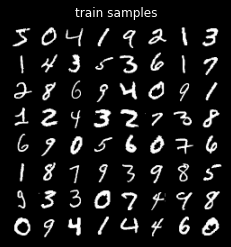

In [ ]:
# Let's visualise images first

dataset = torchvision.datasets.MNIST(".data/", train=True, download=True)

print(dataset)
print(f"# of examples: {len(dataset)}")

x = torch.cat([
    torch.from_numpy(np.array(dataset[idx][0]))[None][None]
    for idx in range(64)
])

plt.imshow(torchvision.utils.make_grid(x).permute(1,2,0))
plt.title("train samples")
plt.axis("off")
plt.show()

Training on the full data may take long time, so we will randomly choose training and validation subsets to reduce waiting.

In [ ]:
train_size, val_size = 1500, 200
np.random.seed(42)
indices = np.random.choice(
    np.arange(dataset.data.shape[0]),
    size=train_size + val_size,
    replace=False
)

targets = dataset.targets[indices].numpy()
data = dataset.data[indices].numpy()

train_targets = targets[:train_size]
train_data = data[:train_size]
train_data = train_data.reshape(train_size, -1)

val_targets = targets[train_size:]
val_data = data[train_size:]
val_data = val_data.reshape(val_size, -1)

Now, we are ready to define our training framework.

We will use simple 2 layers neural network with relu nonlinearity

In [ ]:
# For clarity, we will combine all layers in a single class
# Although, in general, it is better to devote a separate class to each layer 
class TwoLayerNetwork:
    def __init__(
        self,
        in_features: int = 28 * 28,
        num_hidden: int = 512,
        num_classes: int = 10,
        std: float = 1e-4
    ):
        self.params = {}
        self.params['W1'] = std * np.random.randn(in_features, num_hidden)
        self.params['b1'] = np.zeros(num_hidden)
        self.params['W2'] = std * np.random.randn(num_hidden, num_classes)
        self.params['b2'] = np.zeros(num_classes)

    @staticmethod
    def relu(scores):
        return scores.clip(min=0)

    @staticmethod
    def softmax(scores):
        m = scores.max()
        return np.exp(scores - m) / np.sum(np.exp(scores - m), 1)[:, None]
    
    def loss(
        self,
        x: np.ndarray,
        y: np.ndarray
    ) -> Tuple[float, Dict[str, np.ndarray]]:
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.
        
        x: array of shape [BS, D].
        y: array of shape [BS], where each value is between [0, NC)
        
        return:
        loss: Loss for this batch of training
          samples.
        grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, _ = x.shape

        # Forward pass
        scores = x @ W1 + b1
        scores_relu = self.relu(scores)
        scores = scores_relu @ W2 + b2
        soft_scores = self.softmax(scores)

        # Loss computation
        loss = 0.0
        correct_soft_scores = soft_scores[range(x.shape[0]), y]
        loss -= np.log(correct_soft_scores).sum()
        loss /= N

        # Backward pass
        grads = {}
        
        # To read more about dL/dSoftmax computation
        # you can check out following links:
        # https://peterroelants.github.io/posts/cross-entropy-softmax/
        # https://charlee.li/how-to-compute-the-derivative-of-softmax-and-cross-entropy/
        soft_scores_deriv = soft_scores
        soft_scores_deriv[range(N), y] -= 1

        # 2nd layer backward pass
        dW2 = scores_relu.T @ (soft_scores_deriv)
        dW2 /= N
        db2 = np.sum(soft_scores_deriv, 0)
        db2 /= N
        grads['W2'] = dW2
        grads['b2'] = db2
        
        upward_relu_deriv = soft_scores_deriv @ W2.T
        relu_deriv = np.where(scores_relu > 0, upward_relu_deriv, 0)

        # 1st layer backward pass
        dW1 = x.T @ relu_deriv
        dW1 /= N
        db1 = np.sum(relu_deriv, 0)
        db1 /= N
        grads['W1'] = dW1
        grads['b1'] = db1

        return loss, grads

    def train(
      self,
      X: np.ndarray,
      y: np.ndarray,
      X_val: np.ndarray,
      y_val: np.ndarray,
      lr: float = 1e-3, 
      lr_decay=0.95,
      num_iters: int = 100,
      batch_size: int = 128,
      verbose: bool = True) -> Dict[str, List[float]]:
        """
        Train this neural network using stochastic gradient descent.
        
        X: A numpy array of shape (N, D) giving training data.
        y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        X_val: A numpy array of shape (N_val, D) giving validation data.
        y_val: A numpy array of shape (N_val,) giving validation labels.
        lr: Scalar giving learning rate for optimization.
        lr_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        num_iters: Number of steps to take when optimizing.
        batch_size: Number of training examples to use per step.
        verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            indices = np.random.choice(np.arange(X.shape[0]), batch_size)
            X_batch = X[indices]
            y_batch = y[indices]
            
            loss, grads = self.loss(X_batch, y=y_batch)
            loss_history.append(loss)

            for param_key in self.params.keys():
                self.params[param_key] -= lr * grads[param_key]

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            if it % iterations_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (
                  self.predict(X_val) == y_val
                ).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                lr *= lr_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.
        
        X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.
        
        Return:
        y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        scores = X @ W1 + b1
        scores = self.relu(scores)
        scores = scores @ W2 + b2
        y_pred = self.softmax(scores)

        return np.array(y_pred.argmax(1))

In [ ]:
in_features = 28 * 28 
num_hidden = 50
num_classes = 10

net = TwoLayerNetwork(in_features, num_hidden, num_classes)

# Train the network
stats = net.train(
    train_data, train_targets, val_data, val_targets,
    num_iters=3000, batch_size=256,
    lr=0.001, lr_decay=0.95,verbose=True
)

# Predict on the validation set
val_acc = (net.predict(val_data) == val_targets).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 3000: loss 2.302590
iteration 100 / 3000: loss 0.632288
iteration 200 / 3000: loss 0.292970
iteration 300 / 3000: loss 0.205938
iteration 400 / 3000: loss 0.119103
iteration 500 / 3000: loss 0.080174
iteration 600 / 3000: loss 0.077162
iteration 700 / 3000: loss 0.053431
iteration 800 / 3000: loss 0.032173
iteration 900 / 3000: loss 0.026694
iteration 1000 / 3000: loss 0.027650
iteration 1100 / 3000: loss 0.019790
iteration 1200 / 3000: loss 0.014257
iteration 1300 / 3000: loss 0.013606
iteration 1400 / 3000: loss 0.014907
iteration 1500 / 3000: loss 0.012913
iteration 1600 / 3000: loss 0.009804
iteration 1700 / 3000: loss 0.009635
iteration 1800 / 3000: loss 0.007473
iteration 1900 / 3000: loss 0.007422
iteration 2000 / 3000: loss 0.006189
iteration 2100 / 3000: loss 0.005554
iteration 2200 / 3000: loss 0.004184
iteration 2300 / 3000: loss 0.007597
iteration 2400 / 3000: loss 0.004523
iteration 2500 / 3000: loss 0.006615
iteration 2600 / 3000: loss 0.005416
iteration 270

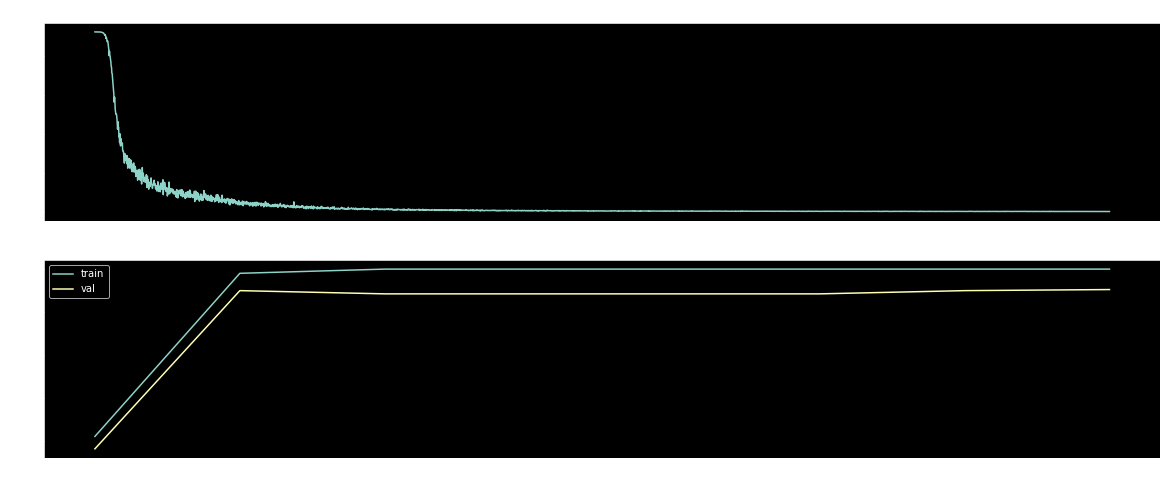

In [ ]:
# Plot the loss function and train / validation accuracies
_, ax = plt.subplots(2, 1, figsize=(20, 8))
ax = ax.flatten()
ax[0].plot(stats['loss_history'])
ax[0].set_title('Loss history')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')

ax[1].plot(stats['train_acc_history'], label='train')
ax[1].plot(stats['val_acc_history'], label='val')
ax[1].set_title('Classification accuracy history')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Classification accuracy')
plt.legend()
plt.show()


---